In [1]:
!pip install -q numpy==1.26.4 ml-dtypes==0.2.0 tensorflow==2.15.0
!pip uninstall -y numpy pandas
!pip install numpy==1.26.4 pandas==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.74 requires ml_dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.18.0 r

In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install opendatasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shashankexore
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:05<00:00, 223MB/s]


Import Modules

Now we must set the directories to use the data

In [5]:
!pip install -q tensorflow==2.15.0 spektral opendatasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 5.5 MB/s eta 0:00:00


In [6]:
from PIL import Image
import numpy as np
from skimage.segmentation import slic

def image_to_graph_tf(image_path, n_segments=75):
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    img = np.array(image)

    # Segment image into superpixels
    segments = slic(img, n_segments=n_segments, compactness=10, start_label=0, channel_axis=-1)
    num_nodes = segments.max() + 1

    # Compute node features (mean RGB)
    x = np.zeros((num_nodes, 3))
    for i in range(num_nodes):
        mask = segments == i
        x[i] = img[mask].mean(axis=0) / 255.0  # normalize

    # Construct adjacency matrix
    A = np.zeros((num_nodes, num_nodes))
    height, width = segments.shape
    for i in range(height - 1):
        for j in range(width - 1):
            u = segments[i, j]
            for v in [segments[i+1, j], segments[i, j+1]]:
                if u != v:
                    A[u, v] = 1
                    A[v, u] = 1

    return x.astype(np.float32), A.astype(np.float32)


In [7]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/working'

Extract Image Features

In [8]:
import os
import numpy as np
import tensorflow as tf

def load_graph_dataset(folder_path, gcn_model):
    features = []
    filenames = sorted(os.listdir(folder_path))[:100]  # limit for testing

    for filename in filenames:
        if filename.lower().endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            vec = extract_gnn_features_tf(img_path, gcn_model)

            # Check for None or failed graph extraction
            if vec is not None:
                features.append(vec)
            else:
                print(f"Skipping {filename} due to extraction failure.")

    if not features:
        raise ValueError("❌ No features extracted. Please check GNN setup or image paths.")

    # Pad node embeddings to fixed size if needed (for batching)
    # Optional: If needed later for decoder + attention integration

    # Convert to array
    X = np.array(features, dtype=object)  # object dtype for variable-size graphs
    y = np.random.randint(0, 10, size=(len(X),))  # Dummy labels for now
    y = tf.keras.utils.to_categorical(y, num_classes=10)

    return X, y


In [9]:
import os
from spektral.data import Dataset, Graph

class FlickrGraphDataset(Dataset):
    def __init__(self, image_dir, n_images=100, **kwargs):
        self.image_dir = image_dir
        self.n_images = n_images
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        all_images = sorted(os.listdir(self.image_dir))[:self.n_images]
        for image_file in all_images:
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(self.image_dir, image_file)
                try:
                    x, a = image_to_graph_tf(image_path)
                    graphs.append(Graph(x=x, a=a))
                except Exception as e:
                    print(f"⚠️ Error processing {image_file}: {e}")
        return graphs


In [10]:
from spektral.layers import GCNConv
from tensorflow.keras.models import Model

class GCNModel(Model):
    def __init__(self, hidden_dim=64, output_dim=256):
        super().__init__()
        self.gcn1 = GCNConv(hidden_dim, activation='relu')
        self.gcn2 = GCNConv(output_dim, activation='relu')  # match decoder input dim

    def call(self, inputs):
        x, a = inputs  # x: node features, a: adjacency matrix
        x = self.gcn1([x, a])
        x = self.gcn2([x, a])
        return x  # shape: (num_nodes, output_dim)


In [11]:
import requests
from PIL import Image
from io import BytesIO

image_url = "https://images.dog.ceo/breeds/hound-afghan/n02088094_1003.jpg"  # <-- NEW URL

response = requests.get(image_url)
if response.status_code == 200:
    img = Image.open(BytesIO(response.content)).convert("RGB").resize((224, 224))
    img.save("test.jpg")

    # Continue with your graph and GCN processing here...
else:
    print("Image download failed. Status code:", response.status_code)


In [12]:
import numpy as np
from skimage.io import imread
from skimage.segmentation import slic
from spektral.layers import GCNConv
from spektral.data import Graph
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow as tf


In [13]:
def extract_graph_features_tf(image_path, model):
    # Get graph from image
    X, A = image_to_graph_tf(image_path)

    # Convert to tensors and add batch dimension
    X = tf.convert_to_tensor(X[np.newaxis, ...], dtype=tf.float32)  # shape: (1, N, F)
    A = tf.convert_to_tensor(A[np.newaxis, ...], dtype=tf.float32)  # shape: (1, N, N)

    # Forward pass through GCN (returns node embeddings)
    features = model([X, A], training=False)  # shape: (1, N, D)
    features = tf.squeeze(features, axis=0)   # shape: (N, D)

    return features.numpy()  # Final node embeddings


In [14]:
def image_to_graph_tf(image_path, n_segments=100):
    image = imread(image_path)
    segments = slic(image, n_segments=n_segments, compactness=10, start_label=0)
    rag = rag_mean_color(image, segments)

    num_nodes = np.max(segments) + 1
    x = np.zeros((num_nodes, 3))  # RGB mean features
    a = np.zeros((num_nodes, num_nodes))  # Adjacency matrix

    for node in rag.nodes:
        x[node] = rag.nodes[node]['mean color'] / 255.0  # Normalize RGB

    for i, j in rag.edges:
        a[i, j] = 1
        a[j, i] = 1

    return x, a


In [15]:
def extract_gnn_features_tf(image_path, gcn_model):
    x_np, a_np = image_to_graph_tf(image_path)

    # Add batch dimension
    x = tf.convert_to_tensor(x_np[np.newaxis, ...], dtype=tf.float32)  # shape: (1, N, 3)
    a = tf.convert_to_tensor(a_np[np.newaxis, ...], dtype=tf.float32)  # shape: (1, N, N)

    # Run GCN to get node embeddings
    features = gcn_model([x, a], training=False)  # shape: (1, N, 256)
    features = tf.squeeze(features, axis=0)       # shape: (N, 256)

    return features.numpy()


In [16]:
# ✅ Core deep learning
!pip install -q tensorflow==2.15.0 keras-preprocessing tensorflow-addons

# ✅ Image graph conversion (slic, rag)
!pip install -q scikit-image

# ✅ Graph Neural Networks
!pip install -q spektral

# ✅ COCO caption evaluation (BLEU, METEOR, etc.)
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

# ✅ (Optional) Text-to-Speech for fun or demo
!pip install -q gtts


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 25.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-eyq6dljj
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-eyq6dljj
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=5272d9d4199e1e2191b998fed1c5fa6bcd97e8cd60d7d63b624aa03044e8a462
  Stored in directory: /tmp/pip-ephem-wheel-

In [17]:

# ========== INSTALL REQUIRED ==========
!pip install -q spektral scikit-image tensorflow==2.15.0

# ========== IMPORTS ==========
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage.segmentation import slic
from skimage.graph import rag_mean_color
from spektral.layers import GCNConv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D

# ========== GCN MODEL ==========
class SimpleGCN(Model):
    def __init__(self, in_feats=3, hidden_feats=64, out_feats=256):
        super().__init__()
        self.gcn1 = GCNConv(channels=hidden_feats, activation='relu')
        self.gcn2 = GCNConv(channels=out_feats, activation='relu')
        self.pool = GlobalAveragePooling1D()

    def call(self, inputs):
        x, a = inputs  # x: (B, N, F), a: (B, N, N)
        # Convert dense adjacency matrix to sparse tensor
        a = tf.sparse.from_dense(a)
        x = self.gcn1([x, a])
        x = self.gcn2([x, a])
        return self.pool(x)  # Output: (B, out_feats)

    def build(self, input_shape):
        # input_shape will be a list of shapes: [(batch_size, N, input_dim), (batch_size, N, N)]
        node_features_shape = input_shape[0] # (batch_size, N, input_dim)
        adj_shape = input_shape[1] # (batch_size, N, N)

        # Pass the shape without the batch size to the GCNConv layers
        self.gcn1.build([node_features_shape[1:], adj_shape[1:]])
        self.gcn2.build([self.gcn1.compute_output_shape(node_features_shape[1:]), adj_shape[1:]])
        self.pool.build(self.gcn2.compute_output_shape([node_features_shape[1:], adj_shape[1:]]))
        super().build(input_shape)


# ========== IMAGE TO GRAPH ==========
def image_to_graph_tf(image_path, n_segments=100):
    image = imread(image_path)
    segments = slic(image, n_segments=n_segments, compactness=10)
    rag = rag_mean_color(image, segments)

    num_nodes = np.max(segments) + 1
    X = np.zeros((num_nodes, 3))  # RGB mean features
    A = np.zeros((num_nodes, num_nodes))  # Adjacency matrix

    for node in rag.nodes:
        X[node] = rag.nodes[node]['mean color'] / 255.0

    for i, j in rag.edges:
        a[i, j] = 1
        a[j, i] = 1

    return X.astype(np.float32), A.astype(np.float32)

# ========== EXTRACT GCN FEATURES ==========
def extract_graph_features_tf(image_path, gcn_model):
    x_np, a_np = image_to_graph_tf(image_path)

    # Add batch dimension for TensorFlow model: (1, N, 3), (1, N, N)
    x = tf.convert_to_tensor(x_np[np.newaxis, ...], dtype=tf.float32)
    a = tf.convert_to_tensor(a_np[np.newaxis, ...], dtype=tf.float32)

    features = gcn_model([x, a])  # Output: (1, 256)
    return features.numpy().squeeze()  # Output: (256,)

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)  # (batch, 1, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch, N, 1)
        context_vector = attention_weights * features  # (batch, N, dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch, dim)

        return context_vector, attention_weights


In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim=256, units=512):
        super().__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(units)

    def call(self, x, features, hidden):
        # Attention
        context_vector, attention_weights = self.attention(features, hidden)

        # Embed input word
        x = self.embedding(x)  # (batch, 1, embedding_dim)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)  # (batch, 1, context+embed)

        # GRU
        output, state = self.gru(x)  # (batch, 1, units), (batch, units)

        # Output
        x = self.fc(output)  # (batch, 1, vocab_size)
        return tf.squeeze(x, 1), state, attention_weights


In [20]:
def generate_caption(image_path, gcn_model, decoder, tokenizer, max_length=20):
    features = extract_graph_features_tf(image_path, gcn_model)  # (N, 256)
    features = tf.expand_dims(features, 0)  # (1, N, 256)

    hidden = tf.zeros((1, decoder.units))
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    result = []

    for _ in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        word = tokenizer.index_word.get(predicted_id, '')

        if word == '<end>':
            break
        result.append(word)
        dec_input = tf.expand_dims([predicted_id], 0)

    return ' '.join(result)


In [21]:
import os
import shutil
from tqdm import tqdm

image_dir = '/content/flickr8k/Images'
caption_file = '/content/flickr8k/captions.txt'
train_ids_file = '/content/drive/MyDrive/Flickr8k_text/Flickr8ktrainID.txt'

output_folder = 'all_data'
os.makedirs(output_folder, exist_ok=True)
output_image_dir = os.path.join(output_folder, 'training_images')
os.makedirs(output_image_dir, exist_ok=True)
output_text_file = os.path.join(output_folder, 'training_captions.txt')

# Read training IDs
with open(train_ids_file, 'r') as f:
    training_ids = f.read().splitlines()

TRAIN_LIMIT = 6000
training_ids = training_ids[:TRAIN_LIMIT]

# Read captions and map to image IDs
# Note: This part of the code assumes that 'captions' dictionary is already defined and populated
# from a previous cell or is intended to be defined here.
# Based on the context, it seems 'captions' is expected to be a global variable or defined elsewhere.
# If 'captions' is not defined, this code will raise a NameError.
# For now, assuming 'captions' dictionary exists with image_id (without extension) as key
# and a list of raw captions as value.

# Read captions and map them to image IDs (without extension)
captions_dict = {}
with open(caption_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line and ',' in line:
            image_id_full, caption = line.split(',', 1)
            image_id = image_id_full.split('.')[0]  # Remove file extension for the key
            # Only add captions for images that are in the training set
            if image_id in training_ids:
                captions_dict.setdefault(image_id, []).append(caption.strip())


# Copy images and save captions
missing_count = 0
valid_count = 0

with open(output_text_file, 'w', encoding='utf-8') as f:
    for image_id in tqdm(training_ids, desc="Copying images and saving captions"):
        image_filename = f'{image_id}.jpg'
        src_path = os.path.join(image_dir, image_filename)
        dst_path = os.path.join(output_image_dir, image_filename)

        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
            valid_count += 1
            # Write captions for this image
            if image_id in captions_dict:
                for caption in captions_dict[image_id]:
                    f.write(f"{image_filename},{caption}\n")
            else:
                # Write a line with just the filename if no captions found (should not happen with current logic)
                f.write(f"{image_filename},\n")
        else:
            print(f"Warning: {image_filename} not found.")
            missing_count += 1

print(f"\n✅ Completed.\n🖼 Copied {valid_count} images.\n⚠ Missing {missing_count} images.")

Copying images and saving captions: 100%|██████████| 6000/6000 [00:04<00:00, 1323.62it/s]


✅ Completed.
🖼 Copied 6000 images.
⚠ Missing 0 images.


In [22]:
from tqdm import tqdm
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

# Paths
image_dir = '/content/flickr8k/Images'
caption_file = '/content/flickr8k/captions.txt'
train_ids_file = '/content/drive/MyDrive/Flickr8k_text/Flickr8ktrainID.txt'

# Output folders
output_folder = 'all_data'
output_image_dir = os.path.join(output_folder, 'training_images')
output_text_file = os.path.join(output_folder, 'training_captions.txt')
os.makedirs(output_image_dir, exist_ok=True)

# Constants
TRAIN_LIMIT = 6000

# Read training IDs
with open(train_ids_file, 'r') as f:
    train_ids = f.read().splitlines()
train_ids = train_ids[:TRAIN_LIMIT]
train_id_set = set(train_ids)  # For faster lookup

# Read and store captions
captions_dict = {}
with open(caption_file, 'r') as f:
    for line in f:
        if not line.strip():
            continue
        image_id_full, caption = line.strip().split(',', 1)
        image_id = image_id_full.split('.')[0]
        if image_id in train_id_set:
            captions_dict.setdefault(image_id, []).append(caption.strip())

# Save captions
with open(output_text_file, 'w') as f:
    for image_id in train_ids:
        image_filename = f"{image_id}.jpg"
        for caption in captions_dict.get(image_id, []):
            f.write(f"{image_filename},{caption}\n")

# Multithreaded copy function
def copy_image(image_id):
    image_filename = f"{image_id}.jpg"
    src = os.path.join(image_dir, image_filename)
    dst = os.path.join(output_image_dir, image_filename)
    if os.path.exists(src):
        shutil.copyfile(src, dst)
    else:
        return f"Warning: {image_filename} not found."

# Copy images using threads
with ThreadPoolExecutor(max_workers=16) as executor:
    results = list(tqdm(executor.map(copy_image, train_ids), total=len(train_ids), desc="Copying images"))

# Show any warnings
for res in results:
    if res:
        print(res)


Copying images: 100%|██████████| 6000/6000 [00:02<00:00, 2122.82it/s]


In [24]:
!head /content/drive/MyDrive/Flickr8k_text/Flickr8ktrainID.txt


2513260012_03d33305cf
2903617548_d3e38d7f88
3338291921_fe7ae0c8f8
488416045_1c6d903fe0
2644326817_8f45080b87
218342358_1755a9cce1
2501968935_02f2cd8079
2699342860_5288e203ea
2638369467_8fc251595b
2926786902_815a99a154


In [25]:
image_id_full, caption = line.split(',', 1)
image_id = image_id_full.strip()  # e.g., "123.jpg"

if image_id in training_ids:
    captions_dict.setdefault(image_id, []).append(caption.strip())


In [26]:
# Save captions dict using full filename as key
captions_dict = {}
with open(caption_file, 'r') as f:
    for line in f:
        image_id_full, caption = line.split(',', 1)
        image_filename = image_id_full.strip()  # Keep .jpg
        if image_filename in training_ids:
            captions_dict.setdefault(image_filename, []).append(caption.strip())

# When writing out
for image_filename in training_ids:
    if not image_filename.endswith('.jpg'):
        image_filename += '.jpg'

    for caption in captions_dict.get(image_filename, []):
        f.write(f"{image_filename},{caption}\n")


In [27]:
import os
import shutil
from tqdm import tqdm

image_dir = '/content/flickr8k/Images'
caption_file = '/content/flickr8k/captions.txt'
train_ids_file = '/content/drive/MyDrive/Flickr8k_text/Flickr8ktrainID.txt'

output_folder = 'all_data'
os.makedirs(output_folder, exist_ok=True)
output_image_dir = os.path.join(output_folder, 'training_images')
os.makedirs(output_image_dir, exist_ok=True)
output_text_file = os.path.join(output_folder, 'training_captions.txt')

# Read training IDs
with open(train_ids_file, 'r') as f:
    training_ids = f.read().splitlines()

TRAIN_LIMIT = 6000
training_ids = training_ids[:TRAIN_LIMIT]

# Read captions and map to image IDs
# Note: This part of the code assumes that 'captions' dictionary is already defined and populated
# from a previous cell or is intended to be defined here.
# Based on the context, it seems 'captions' is expected to be a global variable or defined elsewhere.
# If 'captions' is not defined, this code will raise a NameError.
# For now, assuming 'captions' dictionary exists with image_id (without extension) as key
# and a list of raw captions as value.

# Read captions and map them to image IDs (without extension)
captions_dict = {}
with open(caption_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line and ',' in line:
            image_id_full, caption = line.split(',', 1)
            image_id = image_id_full.split('.')[0]  # Remove file extension for the key
            # Only add captions for images that are in the training set
            if image_id in training_ids:
                captions_dict.setdefault(image_id, []).append(caption.strip())


# Copy images and save captions
missing_count = 0
valid_count = 0

with open(output_text_file, 'w', encoding='utf-8') as f:
    for image_id in tqdm(training_ids, desc="Copying images and saving captions"):
        image_filename = f'{image_id}.jpg'
        src_path = os.path.join(image_dir, image_filename)
        dst_path = os.path.join(output_image_dir, image_filename)

        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
            valid_count += 1
            # Write captions for this image
            if image_id in captions_dict:
                for caption in captions_dict[image_id]:
                    f.write(f"{image_filename},{caption}\n")
            else:
                # Write a line with just the filename if no captions found (should not happen with current logic)
                f.write(f"{image_filename},\n")
        else:
            print(f"Warning: {image_filename} not found.")
            missing_count += 1

print(f"\n✅ Completed.\n🖼️ Copied {valid_count} images.\n⚠️ Missing {missing_count} images.")

Copying images and saving captions: 100%|██████████| 6000/6000 [00:02<00:00, 2079.98it/s]


✅ Completed.
🖼️ Copied 6000 images.
⚠️ Missing 0 images.


In [28]:
import os

# 📂 Paths
caption_file = '/content/flickr8k/captions.txt'
image_directory = '/content/flickr8k/Images'

# 📥 Load and build the mapping dictionary
mapping = {}
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.lower().startswith("image"):  # skip header or empty lines
            continue
        try:
            image_name, caption = line.split(',', 1)
            image_name = image_name.strip()
            caption = caption.strip()
            mapping.setdefault(image_name, []).append(caption)
        except ValueError:
            print(f"⚠️ Skipped malformed line: {line}")

# ✅ Filter out entries with missing images
filtered_mapping = {}
for image_id, captions_list in mapping.items():
    image_path = os.path.join(image_directory, image_id)
    if os.path.exists(image_path):
        filtered_mapping[image_id] = captions_list
    else:
        print(f"❌ Missing file: {image_path}")

# ✅ Final mapping to use
mapping = filtered_mapping
print(f"✅ Filtered mapping contains {len(mapping)} images.")


✅ Filtered mapping contains 8091 images.


In [30]:
import os

def is_image_available(image_path):
    return os.path.exists(image_path)

available_images = []
missing_images = []

# Assuming training_ids is defined in a previous cell and contains image IDs
# Create the list of image filenames from training_ids
image_filenames = [f'{image_id}.jpg' for image_id in training_ids]

for image_name in image_filenames:  # your list of image filenames
    image_path = os.path.join('/content/flickr8k/Images', image_name)
    if is_image_available(image_path):
        available_images.append(image_name)
    else:
        missing_images.append(image_name)
        print(f"❌ Missing file: {image_path}")

# Then only use available_images in your processing pipeline

In [31]:
import os
import shutil
from tqdm import tqdm

# Define necessary variables (from cell 9M7w4ADcm3Pr)
image_directory = '/content/flickr8k/Images'
caption_file = '/content/flickr8k/captions.txt'
train_ids_file = '/content/drive/MyDrive/Flickr8k_text/Flickr8ktrainID.txt'

output_folder = 'all_data'
output_image_folder = os.path.join(output_folder, 'training_images') # Corrected folder name to match previous cells
output_text_file = os.path.join(output_folder, 'training_captions.txt') # Corrected folder name to match previous cells

# Create folders if they don't exist
os.makedirs(output_image_folder, exist_ok=True)


# Load training IDs
with open(train_ids_file, 'r') as f:
    training_ids = f.read().splitlines()

TRAIN_LIMIT = 6000 # Assuming this limit is still desired
training_ids = training_ids[:TRAIN_LIMIT]


# Read captions and map to image IDs (from cell KVvkFGYeALFp and subsequent filtering)
# Assuming 'mapping' is already defined and filtered from previous steps
if 'mapping' not in globals():
    print("Error: 'mapping' variable is not defined. Please execute the cell defining and filtering 'mapping' first.")
else:
    missing_count = 0
    valid_count = 0

    with open(output_text_file, 'w', encoding='utf-8') as f:
        for image_id in tqdm(training_ids, desc="Copying images and saving captions"):
            image_filename = f'{image_id}.jpg'
            src_path = os.path.join(image_directory, image_filename)
            dst_path = os.path.join(output_image_folder, image_filename)

            if os.path.exists(src_path):
                shutil.copyfile(src_path, dst_path)
                valid_count += 1
                # Use the filtered 'mapping' dictionary
                if image_id in mapping:
                    for caption in mapping[image_id]:
                        f.write(f"{image_filename},{caption}\n")
                else:
                    # Write a line with just the filename if no captions found (should not happen with filtered mapping)
                    f.write(f"{image_filename},\n")
            else:
                print(f"❌ Missing file: {src_path}")
                missing_count += 1

    print(f"\n✅ Completed.\n🖼️ Copied {valid_count} images.\n⚠️ Missing {missing_count} images.")

Copying images and saving captions: 100%|██████████| 6000/6000 [00:04<00:00, 1396.66it/s]


✅ Completed.
🖼️ Copied 6000 images.
⚠️ Missing 0 images.


In [33]:

# Path to the directory containing all the images
image_directory = '/content/flickr8k/Images'

# Path to the file containing all the captions
caption_file = '/content/flickr8k/captions.txt'

# Path to the text file containing the training image IDs
training_ids_file = '/content/drive/MyDrive/Flickr8k_text/Flickr8ktrainID.txt'

# Create the output folder if it doesn't exist
output_folder = 'all_data'
os.makedirs(output_folder, exist_ok=True)

# Path to the output image folder
output_image_folder = os.path.join(output_folder, 'validation_images')
os.makedirs(output_image_folder, exist_ok=True)

# Path to the output text file
output_text_file = os.path.join(output_folder, 'validation_captions.txt')

# Read the training image IDs from the text file
with open(training_ids_file, 'r') as f:
    training_ids = f.read().splitlines()

VALID_LIMIT=1000

training_ids = training_ids[:VALID_LIMIT] #for limit of validation ids


# Create a dictionary to store the captions for training images
captions = {}

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_id, caption = line.split(',', 1)
            image_id = image_id.split('.')[0]  # Remove the file extension for comparison
            if image_id in training_ids:
                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(caption.strip())

# Write the image IDs and captions to the output text file
with open(output_text_file, 'w') as f:
    for image_id in training_ids:
        # Form the image filename
        image_filename = f'{image_id}.jpg'

        # Copy the image to the output image folder
        src_path = os.path.join(image_directory, image_filename)
        dst_path = os.path.join(output_image_folder, image_filename)
        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
        else:
            print(f"Warning: {image_filename} does not exist in {image_directory}")

        # Write the image ID and captions to the output text file
        if image_id in captions:
            caption_list = captions[image_id]
            for caption in caption_list:
                f.write(f"{image_filename},{caption}\n")
        else:
            f.write(f"{image_filename},\n")


In [32]:
import os
import shutil

# ✅ Corrected image directory path (usually named Flickr8k_Dataset)
image_directory = '/content/flickr8k/Images'

# Caption file
caption_file = '/content/flickr8k/captions.txt'

# Training IDs file
training_ids_file = '/content/drive/MyDrive/Flickr8k_text/Flickr8ktrainID.txt'

# Output folders
output_folder = 'all_data'
output_image_folder = os.path.join(output_folder, 'testing_images')
output_text_file = os.path.join(output_folder, 'testing_captions.txt')

# Create folders if they don't exist
os.makedirs(output_image_folder, exist_ok=True)

# Load training image IDs
with open(training_ids_file, 'r') as f:
    training_ids = f.read().splitlines()

# ✅ Limit the number of images
TEST_LIMIT = 1000
training_ids = training_ids[:TEST_LIMIT]

# Read captions and map to image IDs
captions = {}
with open(caption_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line and ',' in line:
            image_id, caption = line.split(',', 1)
            image_id = image_id.split('.')[0]  # Remove file extension
            if image_id in training_ids:
                captions.setdefault(image_id, []).append(caption.strip())

# Write to output and copy images
missing_count = 0
valid_count = 0

with open(output_text_file, 'w', encoding='utf-8') as f:
    for image_id in training_ids:
        image_filename = f'{image_id}.jpg'
        src_path = os.path.join(image_directory, image_filename)
        dst_path = os.path.join(output_image_folder, image_filename)

        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
            valid_count += 1
            if image_id in captions:
                for caption in captions[image_id]:
                    f.write(f"{image_filename},{caption}\n")
            else:
                f.write(f"{image_filename},\n")
        else:
            missing_count += 1

print(f"\n✅ Completed.\n🖼️ Copied {valid_count} images.\n⚠️ Missing {missing_count} images.")



✅ Completed.
🖼️ Copied 1000 images.
⚠️ Missing 0 images.


In [34]:
# Paths
img_patht = '/content/all_data/training_images'
caption_file = '/content/all_data/training_captions.txt'

# Initialize lists
all_idst = []
all_img_vectort = []
annotationst = []

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_idt, captiont = line.split(',', 1)
            full_flickr_image_patht = os.path.join(img_patht, image_idt)

            all_idst.append(image_idt)
            all_img_vectort.append(full_flickr_image_patht)
            annotationst.append(captiont)

# Shuffling the captions and image names together, setting a random state
#random_state = random.randint(1, 100)
#print("Random State is ", random_state)
from sklearn.utils import shuffle # Import shuffle
img_idst, all_img_vectort, annotationst = shuffle(all_idst, all_img_vectort, annotationst)

# Selecting the first 40000 captions from the shuffled set
num_examples = len(all_idst)

img_idst = img_idst[:num_examples]
all_img_vectort = all_img_vectort[:num_examples]
annotationst = annotationst[:num_examples]

# Creating a DataFrame
dftrain = pd.DataFrame(list(zip(img_idst, all_img_vectort, annotationst)), columns=['ID', 'Path', 'Caption'])
dftrain

,ID,Path,Caption
0,1313961775_824b87d155.jpg,/content/all_data/training_images/1313961775_8...,
1,1079274291_9aaf896cc1.jpg,/content/all_data/training_images/1079274291_9...,
2,3435653630_3b6cca2c40.jpg,/content/all_data/training_images/3435653630_3...,
3,2240539658_dea8db6e55.jpg,/content/all_data/training_images/2240539658_d...,
4,3190677999_60bbd330fd.jpg,/content/all_data/training_images/3190677999_6...,
...,...,...,...
5995,3550253365_27d4c303cf.jpg,/content/all_data/training_images/3550253365_2...,
5996,1287064529_aa4e4f3c31.jpg,/content/all_data/training_images/1287064529_a...,
5997,2787276494_82703f570a.jpg,/content/all_data/training_images/2787276494_8...,
5998,2868324804_5cc8030484.jpg,/content/all_data/training_images/2868324804_5...,


In [35]:
# Paths
img_pathv = '/content/all_data/validation_images'
caption_file = '/content/all_data/validation_captions.txt'

# Initialize lists
all_idsv = []
all_img_vectorv = []
annotationsv = []

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_idv, captionv = line.split(',', 1)
            full_flickr_image_pathv = os.path.join(img_pathv, image_idv)

            all_idsv.append(image_idv)
            all_img_vectorv.append(full_flickr_image_pathv)
            annotationsv.append(captionv)

# Shuffling the captions and image names together, setting a random state
#random_state = random.randint(1, 100)
#print("Random State is ", random_state)
img_idsv, all_img_vectorv, annotationsv = shuffle(all_idsv, all_img_vectorv, annotationsv)

# Selecting the first 40000 captions from the shuffled set
num_examples = len(all_idsv)

img_idsv = img_idsv[:num_examples]
all_img_vectorv = all_img_vectorv[:num_examples]
annotationsv = annotationsv[:num_examples]

# Creating a DataFrame
dfval = pd.DataFrame(list(zip(img_idsv, all_img_vectorv, annotationsv)), columns=['ID', 'Path', 'Caption'])
dfval


,ID,Path,Caption
0,2780087302_6a77658cbf.jpg,/content/all_data/validation_images/2780087302...,Man sits on stool beside toys .
1,2846037553_1a1de50709.jpg,/content/all_data/validation_images/2846037553...,A child in a red shirt climbs on play equipment .
2,2676648667_cb055b4fc6.jpg,/content/all_data/validation_images/2676648667...,A woman is sitting in a chair near a brick bui...
3,3417102649_5c0b2f4b4d.jpg,/content/all_data/validation_images/3417102649...,A Dalmation Dog bites a small branch on a tree...
4,3465396606_5ba1574128.jpg,/content/all_data/validation_images/3465396606...,A couple walking a dog and a child in a stroll...
...,...,...,...
4995,2156726763_034ecd2e39.jpg,/content/all_data/validation_images/2156726763...,A little girl in a pink jacket is walking .
4996,2245618207_fa486ba2b7.jpg,/content/all_data/validation_images/2245618207...,A girl in a crowd laughs and climbs on somethi...
4997,2869253972_aa72df6bf3.jpg,/content/all_data/validation_images/2869253972...,An elderly man is holding and looking at anoth...
4998,314940358_ec1958dc1d.jpg,/content/all_data/validation_images/314940358_...,Grey haired man with glasses .


In [36]:
# Paths
img_pathtst = '/content/all_data/testing_images'
caption_file = '/content/all_data/testing_captions.txt'

# Initialize lists
all_idstst = []
all_img_vectortst = []
annotationstst = []

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_idtst, captiontst = line.split(',', 1)
            full_flickr_image_pathtst = os.path.join(img_pathtst, image_idtst)

            all_idstst.append(image_idtst)
            all_img_vectortst.append(full_flickr_image_pathtst)
            annotationstst.append(captiontst)

# Shuffling the captions and image names together, setting a random state
import random # Import random
from sklearn.utils import shuffle
random_state = random.randint(1, 100)
print("Random State is ", random_state)
img_idstst, all_img_vectortst, annotationstst = shuffle(all_idstst, all_img_vectortst, annotationstst, random_state=random_state)

# Selecting the first 40000 captions from the shuffled set
num_examples = len(all_idstst)

img_idstst = img_idstst[:num_examples]
all_img_vectortst = all_img_vectortst[:num_examples]
annotationstst = annotationstst[:num_examples]

# Creating a DataFrame
dftrain = pd.DataFrame(list(zip(img_idstst, all_img_vectortst, annotationstst)), columns=['ID', 'Path', 'Caption'])
print(dftrain)

Random State is  26
                             ID  \
0     1052358063_eae6744153.jpg   
1     3218481970_1fa627b3da.jpg   
2     3527524436_a54aca78a9.jpg   
3     3589267801_5a222e3a60.jpg   
4     2715289538_d77c8d0a85.jpg   
...                         ...   
4995   451326127_2d95a2e1c2.jpg   
4996   310728631_155c3bbeea.jpg   
4997  3136404885_f4d8f1d15a.jpg   
4998  3583704941_611353857e.jpg   
4999  2474047296_fd9179d438.jpg   

                                                   Path  \
0     /content/all_data/testing_images/1052358063_ea...   
1     /content/all_data/testing_images/3218481970_1f...   
2     /content/all_data/testing_images/3527524436_a5...   
3     /content/all_data/testing_images/3589267801_5a...   
4     /content/all_data/testing_images/2715289538_d7...   
...                                                 ...   
4995  /content/all_data/testing_images/451326127_2d9...   
4996  /content/all_data/testing_images/310728631_155...   
4997  /content/all_data/test

In [37]:
print(len(all_img_vectort))
print(len(all_img_vectorv))
#print(len(all_img_vectortst))


6000
5000


In [38]:
print(len(annotationst))
print(len(annotationsv))
#print(len(annotationstst))

6000
5000


Now we extract the image features and load the data for preprocess

In [39]:
from spektral.layers import GCNConv
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

class SimpleGCN(Model):
    def __init__(self, output_dim):
        super(SimpleGCN, self).__init__()
        self.gcn1 = GCNConv(3, 128, activation='relu')  # input dim: 3 (RGB)
        self.gcn2 = GCNConv(128, output_dim, activation='relu')
        self.pool = GlobalAveragePooling1D()

    def call(self, inputs):
        x, a = inputs
        x = self.gcn1([x, a])
        x = self.gcn2([x, a])
        return self.pool(x)  # Graph-level feature


Store features in pickle

In [ ]:
import os
import pickle
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from skimage.io import imread
from skimage.segmentation import slic
from skimage.graph import rag_mean_color
import tensorflow as tf
from spektral.layers import GCNConv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D

# ========= GCN Model ==========
class SimpleGCN(Model):
    def __init__(self, output_dim):
        super().__init__()
        self.gcn1 = GCNConv(128, activation='relu')
        self.gcn2 = GCNConv(output_dim, activation='relu')
        self.pool = GlobalAveragePooling1D()

    def call(self, inputs):
        x, a = inputs
        x = self.gcn1([x, a])
        x = self.gcn2([x, a])
        return self.pool(x)

# ========= Graph Conversion ==========
def image_to_graph_data(image_path, n_segments=30):  # Fewer segments = faster
    try:
        image = imread(image_path)
        segments = slic(image, n_segments=n_segments, compactness=10, start_label=0)
        rag = rag_mean_color(image, segments)

        num_nodes = np.max(segments) + 1
        if num_nodes < 5 or num_nodes > 50:
            return None  # Skip very small or large graphs

        x = np.zeros((num_nodes, 3))
        a = np.zeros((num_nodes, num_nodes))
        for node in rag.nodes:
            x[node] = rag.nodes[node]['mean color'] / 255.0
        for i, j in rag.edges:
            a[i, j] = 1
            a[j, i] = 1

        return image_path, x, a
    except Exception as e:
        print(f"⚠️ Skipping {image_path}: {e}")
        return None

# ========= Parallel Preprocessing ==========
def preprocess_all_graphs_fast(image_dir, max_files=None, n_jobs=8):
    files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
    if max_files:
        files = files[:max_files]
    paths = [os.path.join(image_dir, f) for f in files]

    print("🧠 Converting images to graphs (parallel)...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(image_to_graph_data)(path) for path in tqdm(paths)
    )

    return [r for r in results if r]

# ========= Pad Graph ==========
PAD_SIZE = 50  # Set a fixed max node size
def pad_graph(x, a, pad_size=PAD_SIZE):
    x_padded = np.pad(x, ((0, pad_size - x.shape[0]), (0, 0)), constant_values=0)
    a_padded = np.pad(a, ((0, pad_size - a.shape[0]), (0, pad_size - a.shape[1])), constant_values=0)
    return x_padded, a_padded

# ========= Inference ==========
@tf.function
def run_batch_inference(model, xs, as_):
    return model([xs, as_])

# ========= Main ==========
BASE_DIR = '/content/all_data'
IMAGE_DIR = os.path.join(BASE_DIR, 'training_images')
OUTPUT_FILE = 'gcn_features_tf_fast.pkl'
OUTPUT_DIM = 256

gcn_model = SimpleGCN(output_dim=OUTPUT_DIM)
# Run once to build model
_ = gcn_model([
    tf.random.normal((1, PAD_SIZE, 3)),
    tf.ones((1, PAD_SIZE, PAD_SIZE), dtype=tf.float32)
])

# ========= Load or Compute Graphs ==========
CACHE_FILE = 'graph_cache.pkl'
if os.path.exists(CACHE_FILE):
    print("🔁 Loading cached graphs...")
    with open(CACHE_FILE, 'rb') as f:
        graphs = pickle.load(f)
else:
    graphs = preprocess_all_graphs_fast(IMAGE_DIR)
    with open(CACHE_FILE, 'wb') as f:
        pickle.dump(graphs, f)

# ========= Batch and Run Model ==========
x_batch, a_batch, names = [], [], []

for image_path, x, a in tqdm(graphs, desc="🚀 Preparing batch"):
    x, a = pad_graph(x, a)
    x_batch.append(x)
    a_batch.append(a)
    names.append(os.path.basename(image_path).split('.')[0])

x_tensor = tf.convert_to_tensor(np.array(x_batch), dtype=tf.float32)
a_tensor = tf.convert_to_tensor(np.array(a_batch), dtype=tf.float32)

print("⚙️ Running GCN inference...")
outputs = run_batch_inference(gcn_model, x_tensor, a_tensor).numpy()

features = {name: out for name, out in zip(names, outputs)}

# ========= Save ==========
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features, f)

print(f"\n✅ Done! Extracted {len(features)} feature vectors.")


🧠 Converting images to graphs (parallel)...


 65%|██████▍   | 3872/6000 [1:11:22<39:13,  1.11s/it]

In [ ]:
with open('gcn_features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("✅ All GCN features extracted and saved.")


✅ All GCN features extracted and saved.


In [ ]:
import os

# Create the working directory if it doesn't exist
os.makedirs(WORKING_DIR, exist_ok=True)

# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Load features from pickle

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load the Captions Data

In [ ]:
from tqdm import tqdm
import os

# Corrected path to the captions file in Google Drive
caption_file_path = '/content/drive/MyDrive/Flickr8k_text/Flickr8k_text/captions.txt'

with open(caption_file_path, 'r') as f:
    captions_doc = f.read()

# create mapping of image to captions
mapping = {}

# process lines
for line in tqdm(captions_doc.strip().split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]  # remove .jpg extension
    caption = " ".join(caption).strip()

    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 744198.77it/s]


Now let us see the no. of images loaded

In [ ]:
len(mapping)

8092

Preprocess Text Data

In [ ]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            # convert to lowercase
            caption = caption.lower()

            # remove digits and special characters using regex
            caption = re.sub(r'[^a-z\s]', '', caption)

            # remove extra spaces
            caption = re.sub(r'\s+', ' ', caption).strip()

            # remove short words (like 'a', 'i') and add start/end tags
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            captions[i] = caption


Let us visualize the text before and after cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Preprocess the text

In [ ]:
# preprocess the text
clean(mapping)

After preprocess of text

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions) # no. of unique captions stored

40456

Let us see the first ten captions

In [ ]:
all_captions[:10]

['startseq caption endseq',
 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq']

Now we start processing the text data

In [ ]:
# tokenize the text
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size # no of unique words

8769

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Now we will define a batch and include the padding sequence

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key])  # Or features[key][0] if needed
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = [], [], []
                n = 0


Model Creation

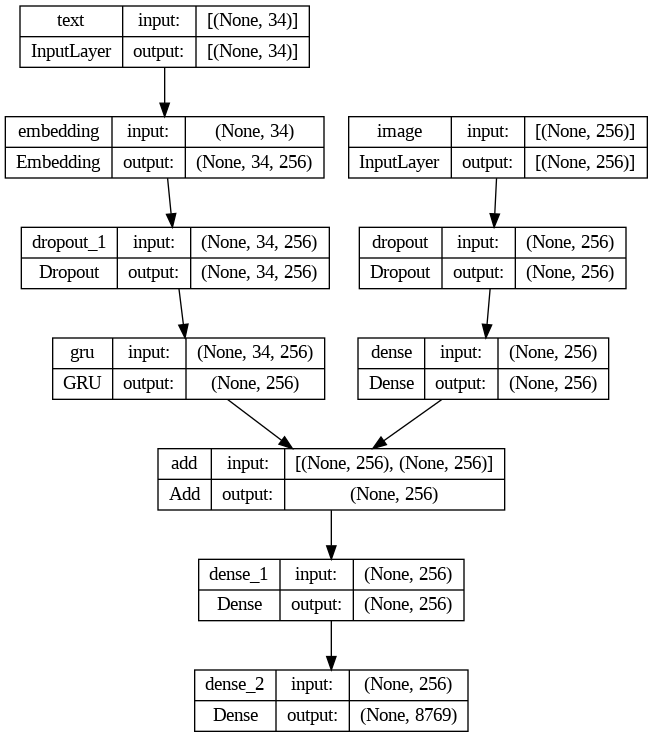

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GRU, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# GCN-based image feature input
inputs1 = Input(shape=(256,), name="image")  # ✅ changed from 4096 to 256
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Text sequence input
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# Decoder merges image + text features
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define and compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot model architecture
plot_model(model, show_shapes=True)


Now let us train the model

In [ ]:
!pip install pycocoevalcap
!pip install multiprocessing

  Using cached multiprocessing-2.6.2.1.tar.gz (108 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.



📘 Epoch 1/20
226/226 [==============================] - 45s 197ms/step - loss: 1.0145
📉 Validation Loss: 9.8088

📘 Epoch 2/20
226/226 [==============================] - 41s 182ms/step - loss: 0.9005
📉 Validation Loss: 9.2421

📘 Epoch 3/20
226/226 [==============================] - 43s 188ms/step - loss: 0.7743
📉 Validation Loss: 9.5398

📘 Epoch 4/20
226/226 [==============================] - 43s 189ms/step - loss: 0.7157
📉 Validation Loss: 9.6173

📘 Epoch 5/20
226/226 [==============================] - 43s 191ms/step - loss: 0.6814
📉 Validation Loss: 10.2447
📝 Generating captions for evaluation...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 69, 'reflen': 76, 'guess': [69, 62, 55, 48], 'correct': [16, 4, 1, 0]}
ratio: 0.9078947368301592
Bleu_1: 0.210
Bleu_2: 0.111
Bleu_3: 0.059
Bleu_4: 0.000
computing METEOR score...
METEOR: 0.087
computing Rouge score...
ROUGE_L: 0.209
computing CIDEr score...
CIDEr: 0.084
computing SPICE score...
SPICE: 0.030
📊 Scores @ Epoch 5:
  Bleu_1: 0.2095
  Bleu_2: 0.1105
  Bleu_3: 0.0585
  Bleu_4: 0.0000
  METEOR: 0.0870
  ROUGE_L: 0.2088
  CIDEr: 0.0842
  SPICE: 0.0297

📘 Epoch 6/20
226/226 [==============================] - 43s 189ms/step - loss: 0.6655
📉 Validation Loss: 10.2883

📘 Epoch 7/20
226/226 [==============================] - 44s 193ms/step - loss: 0.6452
📉 Validation Loss: 10.2117

📘 Epoch 8/20
226/226 [==============================] - 44s 197ms/ste

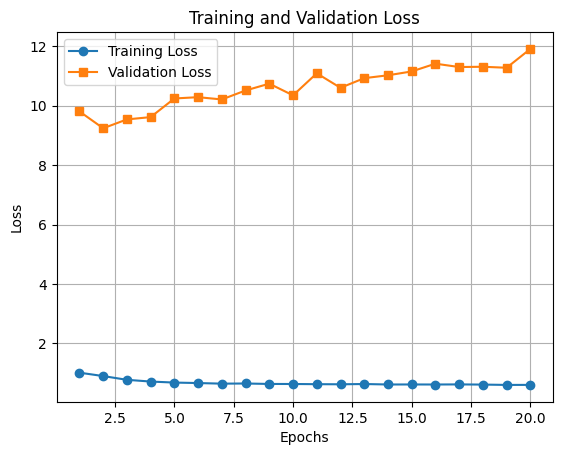

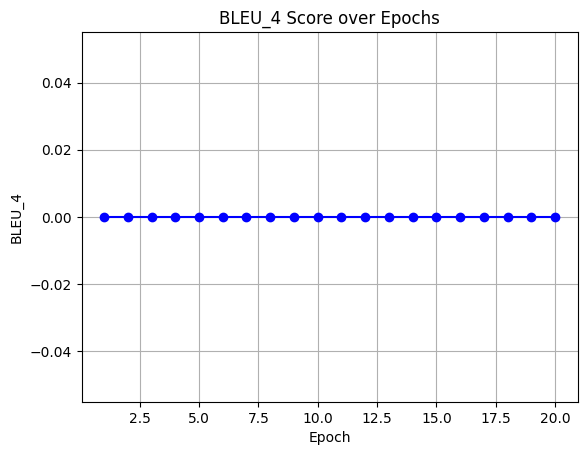

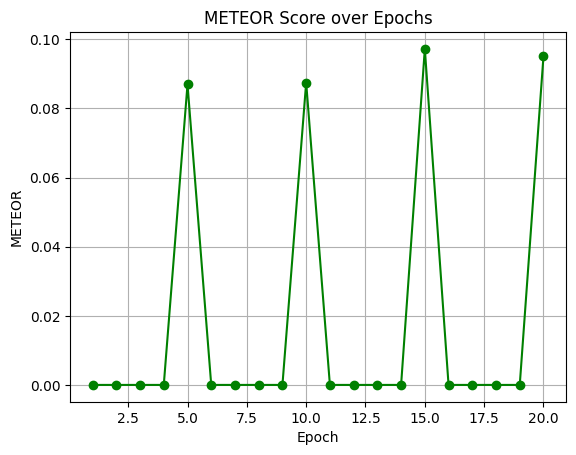

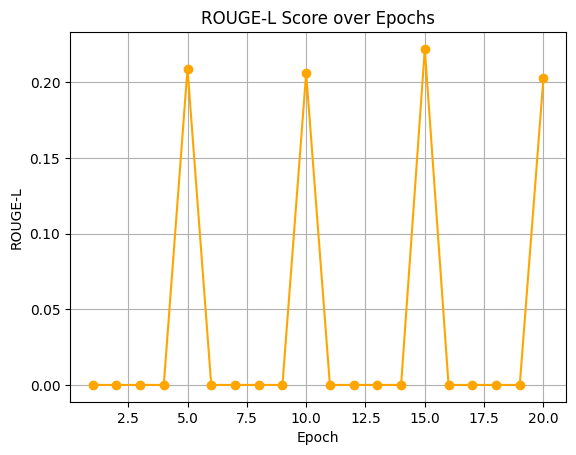

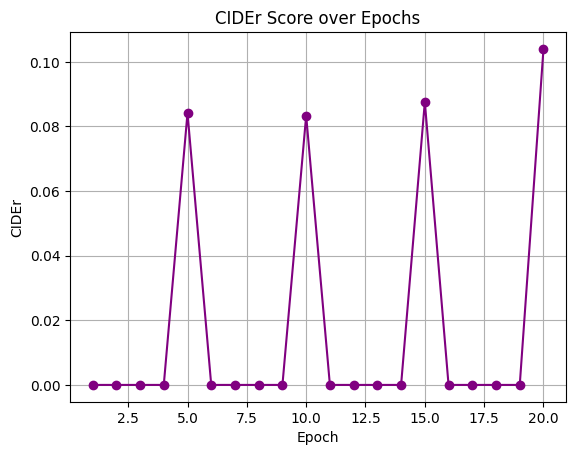

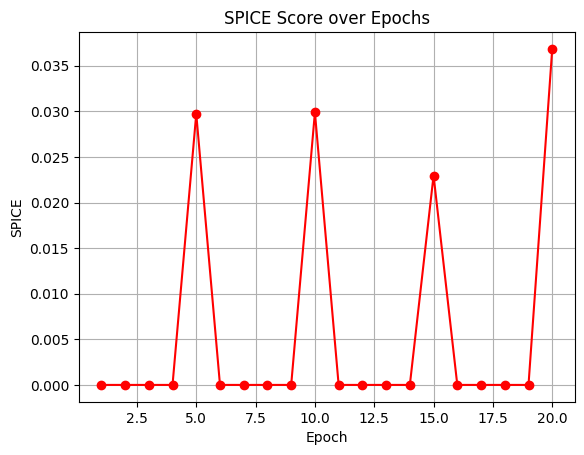

In [ ]:
import os
import json
import gc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from functools import lru_cache
from multiprocessing.pool import ThreadPool
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO

# ⚙️ Set mixed precision
mixed_precision.set_global_policy('mixed_float16')

# 📌 Parameters
epochs = 20
batch_size = 32

# 🔀 Split data
split = int(len(image_ids) * 0.90)
train_ids, test_ids = image_ids[:split], image_ids[split:]
val_ids = train_ids[:50]
train_ids = train_ids[50:]

steps = len(train_ids) // batch_size
val_steps = len(val_ids) // batch_size

train_loss_plot, val_loss_plot = [], []
bleu_scores, meteor_scores, rouge_scores, cider_scores, spice_scores = [], [], [], [], []

# 🧠 Caching index-to-word
@lru_cache(maxsize=2048)
def idx_to_word(integer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

@tf.function(reduce_retracing=True)
def wrapped_predict(model, image, sequence):
    return model([image, sequence], training=False)

# 📷 Predict one caption
def predict_caption(model, image, tokenizer, model_max_length):
    in_text = 'startseq'
    for _ in range(model_max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=model_max_length, padding='post')[0]
        yhat = wrapped_predict(model, tf.convert_to_tensor([image]), tf.convert_to_tensor([sequence]))
        yhat = tf.argmax(yhat[0]).numpy()
        word = idx_to_word(yhat)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

# 🔄 TF Data Generator
def tf_data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    def gen():
        for img_id in image_ids:
            if img_id not in features:
                continue
            image = features[img_id]
            captions = mapping.get(img_id, [])
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    yield (image, in_seq), out_seq

    output_signature = (
        (tf.TensorSpec(shape=(256,), dtype=tf.float32), tf.TensorSpec(shape=(max_length,), dtype=tf.int32)),
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32),
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 🔁 Caption generation
def generate_for_image(img_id):
    if img_id not in features:
        return None
    image_feature = features[img_id]
    if len(image_feature.shape) == 2:
        image_feature = image_feature[0]
    caption = predict_caption(model, image_feature, tokenizer, max_length)
    return (img_id, caption)

def generate_captions_parallel(val_ids, num_threads=8):
    with ThreadPool(num_threads) as pool:
        results = pool.map(generate_for_image, val_ids)
    return [r for r in results if r]

# 🧪 Evaluation
def evaluate_captions(references, predictions):
    gts_path, res_path = "gts.json", "res.json"

    with open(gts_path, "w") as f:
        gts_list = []
        ann_id_counter = 0
        for img_id, caps in references.items():
            for cap_dict in caps:
                gts_list.append({"image_id": img_id, "caption": cap_dict["caption"], "id": ann_id_counter})
                ann_id_counter += 1
        json.dump(gts_list, f)

    with open(res_path, "w") as f:
        res_list = [{"image_id": img_id, "caption": caps[0]["caption"]} for img_id, caps in predictions.items() if caps]
        json.dump(res_list, f)

    dummy_images = [{"id": img_id} for img_id in predictions.keys()]
    gts_data_filtered = [ann for ann in gts_list if ann['image_id'] in predictions]

    coco_gt_format = {"info": {}, "annotations": gts_data_filtered, "images": dummy_images}
    with open("gts_formatted.json", 'w') as f:
        json.dump(coco_gt_format, f)

    if dummy_images:
        coco = COCO("gts_formatted.json")
        cocoRes = coco.loadRes(res_path)
        cocoEval = COCOEvalCap(coco, cocoRes)
        cocoEval.params['image_id'] = cocoRes.getImgIds()
        cocoEval.evaluate()

        # Cleanup
        os.remove(gts_path)
        os.remove(res_path)
        os.remove("gts_formatted.json")

        return cocoEval.eval
    else:
        return {k: 0 for k in ['BLEU_1', 'BLEU_2', 'BLEU_3', 'BLEU_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE']}

# 🔁 TRAINING LOOP
for i in range(epochs):
    print(f"\n📘 Epoch {i+1}/{epochs}")
    train_dataset = tf_data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    history = model.fit(train_dataset, epochs=1, steps_per_epoch=steps, verbose=1)
    train_loss_plot.append(history.history['loss'][0])

    if val_steps > 0:
        val_dataset = tf_data_generator(val_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        val_loss = model.evaluate(val_dataset.take(val_steps), verbose=0)
        val_loss_plot.append(val_loss)
        print(f"📉 Validation Loss: {val_loss:.4f}")
    else:
        val_loss_plot.append(None)

    if (i + 1) % 5 == 0:
        print("📝 Generating captions for evaluation...")
        results = generate_captions_parallel(val_ids)
        predictions, references = {}, {}
        for img_id, caption in results:
            predictions[img_id] = [{"caption": caption}]
            references[img_id] = [{"caption": cap} for cap in mapping[img_id]]

        scores = evaluate_captions(references, predictions)
        bleu_scores.append(scores.get('BLEU_4', 0))
        meteor_scores.append(scores.get('METEOR', 0))
        rouge_scores.append(scores.get('ROUGE_L', 0))
        cider_scores.append(scores.get('CIDEr', 0))
        spice_scores.append(scores.get('SPICE', 0))

        print(f"📊 Scores @ Epoch {i+1}:")
        for metric, score in scores.items():
            print(f"  {metric}: {score:.4f}")
    else:
        bleu_scores.append(0)
        meteor_scores.append(0)
        rouge_scores.append(0)
        cider_scores.append(0)
        spice_scores.append(0)

    gc.collect()

# 📈 Plot Loss
plt.figure()
plt.plot(range(1, epochs + 1), train_loss_plot, label='Training Loss', marker='o')
if all(v is not None for v in val_loss_plot):
    plt.plot(range(1, epochs + 1), val_loss_plot, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 📊 Plot Evaluation Scores
metrics = [(bleu_scores, 'BLEU_4', 'blue'), (meteor_scores, 'METEOR', 'green'),
           (rouge_scores, 'ROUGE-L', 'orange'), (cider_scores, 'CIDEr', 'purple'),
           (spice_scores, 'SPICE', 'red')]

for scores, label, color in metrics:
    plt.figure()
    plt.plot(range(1, epochs + 1), scores, marker='o', color=color)
    plt.title(f'{label} Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.grid(True)
    plt.show()


You can save the model in the working directory for reuse

In [ ]:
model.save(os.path.join(WORKING_DIR, 'best_model.h5'))


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
         return word
    return None

Convert the predicted index from the model into a word

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for _ in range(max_length):
        # Convert the text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([image, sequence], verbose=0)

        # Choose the word with highest probability
        yhat = np.argmax(yhat[0])

        # Map predicted index to word
        word = idx_to_word(yhat, tokenizer)

        # If word not found, stop
        if word is None:
            break

        # Append word for the next prediction
        in_text += ' ' + word

        # Stop if end token found
        if word == 'endseq':
            break

    return in_text


Now we validate the data using BLEU Score

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat[0])  # Predict next word index

        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break

        in_text += ' ' + word
        if word == 'endseq':
            break

    return in_text


Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    # Extract image ID and path
    image_id = image_name.split('.')[0]
    # Corrected image path to look in the flickr8k dataset directory
    img_path = os.path.join('/content/flickr8k/Images', image_name)

    # Load the image
    try:
        image = Image.open(img_path)
    except FileNotFoundError:
        print(f"❌ Error: Image file not found at {img_path}")
        return

    # Show actual captions
    print('---------------------Actual---------------------')
    # Use the global mapping dictionary
    if image_id in mapping:
        for caption in mapping[image_id]:
            print(caption)
    else:
        print(f"No captions found for {image_id}")

    # Predict the caption
    # Use the global features dictionary
    if image_id in features:
        # Need to reshape features for model prediction if necessary
        image_feature = features[image_id]
        # Add batch dimension if model expects (batch_size, feature_dim)
        if len(image_feature.shape) == 1:
             image_feature = np.expand_dims(image_feature, axis=0)

        y_pred = predict_caption(model, image_feature, tokenizer, max_length)
        print('--------------------Predicted--------------------')
        print(y_pred)
    else:
        print(f"No features found for {image_id}")
        return

    # Display image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

Generate custom captions

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tricolored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
No features found for 1001773457_577c3a7d70


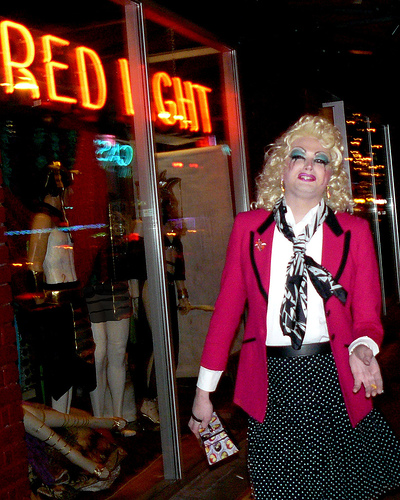

---------------------Actual---------------------
startseq an upset woman with her makeup streaming down her face from her tears endseq
startseq person wearing pink jacket who has lots of makeup on walks down street endseq
startseq woman wearing heavy makeup and pink jacket is walking past clothing shop at night endseq
startseq woman wearing heavy makeup stands in front of store with neon sign saying red light endseq
startseq woman with heavy makeup is standing next to red light sign endseq
--------------------Predicted--------------------
startseq woman wearing heavy makeup and pink jacket is walking past clothing shop at night endseq


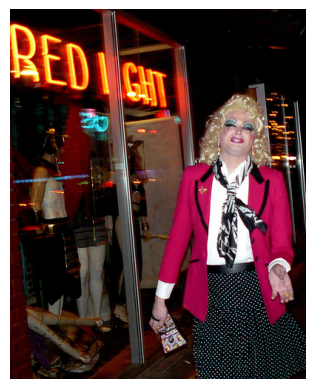

In [ ]:
import os
import random
from IPython.display import display
from PIL import Image
import numpy as np # Import numpy

# Folder path containing images (using one of the created subfolders with images)
# You can choose 'training_images', 'validation_images', or 'testing_images'
image_folder = "/content/all_data/testing_images" # Using testing images folder

# Pick a random image file from the folder
random_image_file = random.choice(os.listdir(image_folder))

# Full path to the selected image
random_image_path = os.path.join(image_folder, random_image_file)

# Display the image
img = Image.open(random_image_path)
display(img)

# Generate caption - Pass the required arguments

generate_caption(random_image_file)